<a href="https://colab.research.google.com/github/ricardosaj/ProjetoFinalBootcampAluraDataScience/blob/main/ProjetoBCFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Projeto para prever necessidade de leito de UTI 


In [ ]:
!pip install neuralprophet

In [ ]:
import pandas as pd
import numpy as np
from neuralprophet import NeuralProphet
from matplotlib import pyplot as plt
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report, ConfusionMatrixDisplay, f1_score
from sklearn.base import BaseEstimator, TransformerMixin
from joblib import dump, load

In [ ]:
!pip install openpyxl==3.0.0

In [ ]:
dados = pd.read_excel("https://github.com/ricardosaj/ProjetoFinalBootcampAluraDataScience/blob/main/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true")
dados.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,

In [ ]:
dados.PATIENT_VISIT_IDENTIFIER.unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
dados.columns

Index(['PATIENT_VISIT_IDENTIFIER', 'AGE_ABOVE65', 'AGE_PERCENTIL', 'GENDER',
       'DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3',
       'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6',
       ...
       'TEMPERATURE_DIFF', 'OXYGEN_SATURATION_DIFF',
       'BLOODPRESSURE_DIASTOLIC_DIFF_REL', 'BLOODPRESSURE_SISTOLIC_DIFF_REL',
       'HEART_RATE_DIFF_REL', 'RESPIRATORY_RATE_DIFF_REL',
       'TEMPERATURE_DIFF_REL', 'OXYGEN_SATURATION_DIFF_REL', 'WINDOW', 'ICU'],
      dtype='object', length=231)

In [ ]:
dados.dtypes

PATIENT_VISIT_IDENTIFIER        int64
AGE_ABOVE65                     int64
AGE_PERCENTIL                  object
GENDER                          int64
DISEASE GROUPING 1            float64
                               ...   
RESPIRATORY_RATE_DIFF_REL     float64
TEMPERATURE_DIFF_REL          float64
OXYGEN_SATURATION_DIFF_REL    float64
WINDOW                         object
ICU                             int64
Length: 231, dtype: object

In [ ]:
print("\nTratamento da Base com Label Encoder")

pacientes_UTI = dados[['PATIENT_VISIT_IDENTIFIER','ICU']].query('ICU == 1').groupby('PATIENT_VISIT_IDENTIFIER').min()
dados_tratados = dados.query('ICU != 1').drop('ICU', axis=1)
dados_tratados = dados_tratados.join(pacientes_UTI, on='PATIENT_VISIT_IDENTIFIER', how='left')
dados_tratados['ICU'] = dados_tratados['ICU'].fillna(0) 
print("\nRemovemos as linhas com ICU(UTI) igual a 1 e remarcamos a coluna com base no PATIENT_VISIT_IDENTIFIER que chegou na UTI")
print(f"Distribuição de ICU na base tratada (%)\n{dados_tratados['ICU'].value_counts(normalize=True)*100}")

features_continuas_colunas = dados_tratados.iloc[:, 13:-2].columns
features_continuas = dados_tratados.groupby("PATIENT_VISIT_IDENTIFIER",as_index=False)[features_continuas_colunas].fillna(method='bfill').fillna(method='ffill')
features_categoricas = dados_tratados.iloc[:, :13]
saida = dados_tratados.iloc[:, -2:]
dados_tratados = pd.concat([features_categoricas, features_continuas, saida], ignore_index=True,axis=1)
dados_tratados.columns = dados.columns
print("\nAjustamos os valores continuos que estavam com Nam para o valor anterior ou posterior")

descricao = dados_tratados.describe().T
colunas_sem_variacao = descricao[descricao['min'] == descricao['max']].index
if len(colunas_sem_variacao) !=0:
  dados_tratados.drop(colunas_sem_variacao, axis=1)
  print("\nRemovemos as colunas que os valores são iguais para todas as linhas")

linhas_com_nam = dados_tratados.describe(include='all').loc['count'].max()-dados_tratados.describe(include='all').loc['count'].min()
if linhas_com_nam !=0:
  if linhas_com_nam <= len(dados_tratados)*.1:
    dados_tratados.dropna(inplace=True)
    print(f"\nAs linhas ainda com Nam ({linhas_com_nam} linhas, {linhas_com_nam/len(dados_tratados):.2%} do total) foram eliminadas")
  else:
    print(f"\nTemos linhas ainda com Nam ({linhas_com_nam} linhas, {linhas_com_nam/len(dados_tratados):.2%} do total) precisam ser tratadas")

dados_tratados.reset_index(drop=True, inplace=True)
print(f"\nO index foi resetado: {dados_tratados.index}")

colunas_categoricas = list(set(dados_tratados.columns)-set(dados_tratados.describe().columns)-{'WINDOW'})
if len(colunas_categoricas) ==1:
  dados_LE = dados_tratados.copy()
  LE = LabelEncoder()
  dados_LE[colunas_categoricas] = pd.DataFrame(LE.fit_transform(np.ravel(dados_tratados[colunas_categoricas])))
  print(f"\nColuna com objeto categórico ({colunas_categoricas[0]}) foi transformada em numérica no DataFrame dados_LE.\nFormato: {dados_LE.shape}")
else:
  print(f"\nColunas com objetos categóricos precisam ser tratados: {', '.join(colunas_categoricas)}")

print(f"\nFormato final do DataFrame dados_tratados: {dados_tratados.shape}\n")


Tratamento da Base com Label Encoder

Removemos as linhas com ICU(UTI) igual a 1 e remarcamos a coluna com base no PATIENT_VISIT_IDENTIFIER que chegou na UTI
Distribuição de ICU na base tratada (%)
0.0    67.375887
1.0    32.624113
Name: ICU, dtype: float64

Ajustamos os valores continuos que estavam com Nam para o valor anterior ou posterior

Removemos as colunas que os valores são iguais para todas as linhas

As linhas ainda com Nam (5.0 linhas, 0.36% do total) foram eliminadas

O index foi resetado: RangeIndex(start=0, stop=1405, step=1)

Coluna com objeto categórico (AGE_PERCENTIL) foi transformada em numérica no DataFrame dados_LE.
Formato: (1405, 231)

Formato final do DataFrame dados_tratados: (1405, 231)



In [ ]:
print("\nTratamento da Base com One Hot Encoder")

if len(colunas_categoricas) ==1:
  categorica = np.array(dados_tratados[colunas_categoricas]).reshape(-1, 1)
  OHE = OneHotEncoder()
  categorica_OHE = pd.DataFrame(OHE.fit_transform(categorica).toarray())
  dados_OHE = pd.concat([dados_tratados.drop(colunas_categoricas, axis=1), categorica_OHE], ignore_index=True, axis=1)
  colunas = list(dados_tratados.columns)
  colunas.remove(colunas_categoricas[0])
  colunas_novas = list(dados_tratados[colunas_categoricas[0]].unique())
  colunas_novas.sort()
  colunas.extend(colunas_novas)
  dados_OHE.columns = colunas
  print(f"\nTrocamos o campo AGE_PERCENTIL pelos campos binários {', '.join(colunas_novas)}")
  print(f"\nFormato final do DataFrame dados_OHE: {dados_OHE.shape}")
else:
  print(f"\nColunas com objetos categóricos precisam ser tratados: {', '.join(colunas_categoricas)}")


Tratamento da Base com One Hot Encoder

Trocamos o campo AGE_PERCENTIL pelos campos binários 10th, 20th, 30th, 40th, 50th, 60th, 70th, 80th, 90th, Above 90th

Formato final do DataFrame dados_OHE: (1405, 240)


In [ ]:
def adiciona_janela(dados_anterior, dados_janela, colunas=features_continuas_colunas):
  """
  ________________________________________________________________________________________________________________
  ENTRADAS
  --------
  dados_anterior: DataFrame
      dados da janela atual que está sendo observada. Por exemplo o filtro WINDOW == '0-2'

  dados_janela: DataFrame
      dados da janela que será adcionada. Seguindo o exemplo o filtro WINDOW == '2-4'

  colunas: list
      lista de colunas que devem ser adiciondos, não deveríamos adicionar novamente os dados categóricos por 
      exemplo. Por isso, por padrão são utilizadas as features continuas
  ________________________________________________________________________________________________________________
  SAIDAS
  ------
  DataFrame
      Nova base de dados partindo do dados_janela e adcionando as colunas seleciondas da base dados_anterior, 
      também adicionando a variação dessas colunas contra a janela anterior e removendo o que não for útil
  """
  d1 = dados_janela.set_index('PATIENT_VISIT_IDENTIFIER')
  d2 = dados_anterior.set_index('PATIENT_VISIT_IDENTIFIER')
  sufixo = ' ' + str(dados_anterior.loc[0,"WINDOW"])
  dados_novo = d1.join(d2[colunas], how='left', rsuffix=sufixo).reset_index()

  for _ in colunas:
    coluna = 'var ' + _ + sufixo
    coluna_ = _ + sufixo
    dados_novo[coluna] = dados_novo[_] - dados_novo[coluna_]

  descricao = dados_novo.describe().T
  colunas_sem_variacao = descricao[descricao['min'] == descricao['max']].index
  if len(colunas_sem_variacao) !=0:
    dados_novo.drop(colunas_sem_variacao, axis=1)
    print("\nRemovemos as colunas que os valores são iguais para todas as linhas")

  linhas_com_nam = dados_novo.describe(include='all').loc['count'].max()-dados_novo.describe(include='all').loc['count'].min()
  if linhas_com_nam !=0:
    if linhas_com_nam <= len(dados_novo)*.1:
      dados_novo.dropna(inplace=True)
      print(f"\nAs linhas ainda com Nam ({linhas_com_nam} linhas, {linhas_com_nam/len(dados_novo):.2%} do total) foram eliminadas")
    else:
      print(f"\nTemos linhas ainda com Nam ({linhas_com_nam} linhas, {linhas_com_nam/len(dados_novo):.2%} do total) precisam ser tratadas")
  print(f'\nBase nova de tamanho: {dados_novo.shape}')
  return dados_novo

In [ ]:
class remove_corr(BaseEstimator, TransformerMixin):
  """
  ________________________________________________________________________________________________________________
  Seleciona os dados com base na correlação deles entre si (dentro do X) e com a variável objetivo (y)
  ________________________________________________________________________________________________________________
  PARAMETROS
  ----------
  corr_maxima: float
      define o máximo valor permitido para as correlações entre as variávies de X, acima disso as variáveris X
      serão desconsideradas (mantendo apenas uma entre as duas que tem alta correlação entre si)

  corr_minima: float
      define o valor minimo para a correlação entre o y e as variaveis de X, abaixo disso as variaves de X 
      serão eliminadas
  ________________________________________________________________________________________________________________
  ATRIBUTOS
  ---------
  excluir: list
      Lista das colunas/variáveris a serem excluidas do X, criado pelo método fit()

  """
  def __init__( self, corr_maxima = 0.95, corr_minima=0.05):
    self.corr_maxima = corr_maxima
    self.corr_minima = corr_minima

  def fit( self, X, y):
    """
    ________________________________________________________________________________________________________________
    faz o fit do modelo, salvando uma lista de colunas/variáveris a serem excluidas do X
    ________________________________________________________________________________________________________________
    ENTRADAS
    ----------
    X: DataFrame
        a base das variáveis utilizadas para tentar definir o y

    y: Series
        a variável objetivo que buscamos prever
    ________________________________________________________________________________________________________________
    SAIDA
    -----
    objeto da classe remove_corr
        modelo de seleção já configurado aguardando a utilização do método transform()
        
    """
    corr = X.corr().abs()
    corr_diagonal = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    self.excluir = [coluna for coluna in corr_diagonal.columns if any(corr_diagonal[coluna] > self.corr_maxima)]
    X_ = X.drop(self.excluir, axis=1)
    X_ = X_.join(y, how='left')
    X_corr = X_.corr().abs()
    self.excluir.extend(list(X_corr.query('ICU < @self.corr_minima')['ICU'].index))

    return self 
    
  def transform(self, X, y = None):
    """
    ________________________________________________________________________________________________________________
    remove as colunas/variáveis definidas pelo método fit() do DataFrame X passado
    ________________________________________________________________________________________________________________
    ENTRADAS
    ----------
    X: DataFrame
        a base das variáveis utilizadas para tentar encontrar definir o y que será transformada

    y: Series
        a variável objetivo que buscamos prever. 
        Não será utilizada e não precisa ser passada.
    ________________________________________________________________________________________________________________
    SAIDA
    -----
    DataFrame
        novo DataFrame do X após a exclusão das colunas/variáveis definidas no fit()
        
    """
    X = X.drop(self.excluir, axis=1)
    return X

In [ ]:
class seleciona_modelo():
  """
  ________________________________________________________________________________________________________________
  A partir de um modelo de classificação definido, está classe permite você testar diversas opções de pipelines
  e configurações do modelo escolhido, com o objetivo de encontrar o que possuí maior precisão para definir o y.

  Além disso, após os testes podemos criar o melhor pipeline, treina-lo, testa-lo e salva-lo em um aquivo
  ________________________________________________________________________________________________________________
  PARAMETROS
  ----------
  modelo: modelo de classificação do sklearn
      modelo que será utilizado nos testes do pipeline e de seus paramêtros, bem como no pipeline final
  ________________________________________________________________________________________________________________
  ATRIBUTOS
  ---------
  metrica: str
      metrica utilizada nos cálculos comparativos dos testes, definida no método testa_parametros()
  
  Xs: dict
      dicionários dos Xs testados com base nas bases envidas no método testa_parametros()

  ys: dict
      dicionários dos ys testados com base nas bases envidas no método testa_parametros()

  resultados: DataFrame
      DataFrame com os resultados do método testa_parametro(), tem os resultados e as etapas do pipeline utilizado

  indice: int
      indice da linha dos resultados que iremos utilizar para criar o pipeline final, criado no método cria_pipeline()

  pipe: Pipeline
      pipeline final criado no método cria_pipeline()

  base: str
      Nome da base que teve o melhor resultado, para utilização na avaliação das métricas do pipeline final.
      Criada no método cria_pipeline()
  
  modelo_final: Pipeline
      modelo do pipeline utilizado para ser salvo no arquivo. 
      Criado no método cria_modelo_final() ou cria_salva_modelo_final()
  """
  def __init__( self, modelo):
    self.modelo = modelo

  def testa_parametros(self, parametros, lista_dados, lista_reescalas=['nenhuma'], 
                      selecao_menor=-30, selecao_maior=30, passo=30, n_splits = 5, n_repeats=10, metrica='roc_auc'):
    """
    ________________________________________________________________________________________________________________
    testa deiveros parametros, seleções e reescalas conforme solicitação do usuário

    por padrão todas os testes colocam no lógica do pipeline um objeto da classe remove_corr(), devido a testes
    anteriores demonstrarem a eficácia da utilização desta seleção prévia
    ________________________________________________________________________________________________________________
    ENTRADAS
    --------
    parametros: dict
        dicionário com os parametros do modelo que queremos testar. lembrando que o formato de cada item é o nome 
        parametro e a lista de valores que se deseja testar

    lista_dados: list de tuplas
        lista contendo tuplas com a base que queremos testar (DataFrame) e nome que iremos identifica-la (str)
        Exemplo: [(dados_LE,'LE'),(dados_OHE,'OHE')]
    
    lista_reescalas: list
        lista deve conter as funções de reescala que queremos utilizar ou a string 'nenhuma'
    
    selecao_menor: int
        valor do percentual (será divido por 100) que queremos distanciar da média no paramêtro threshold da função
        SelectFromModel. Este é o valor inferior do range que será testado.
        Os valores menores ou iguais a -100 do range farão com que não se aplique essa segunda seleção no número
    
    selecao_maior: int
        valor do percentual (será divido por 100) que queremos distanciar da média no paramêtro threshold da função
        SelectFromModel. Este é o valor superio do range que será testado.
        Os valores menores ou iguais a -100 do range farão com que não se aplique essa segunda seleção no número

    passo: int
        valor do aumento gradual que será colocado na selecao_menor até chegar na selecao_maior dentro do range.
    
    n_splits: int
        número de divisões que será realizada no objeto RepeatedStratifiedKFold durante os testes

    n_repeats: int
        número de repetições que será realizada no objeto RepeatedStratifiedKFold durante os testes
    
    metrica: str
        metrica utilizada nos cálculos comparativos dos testes
    ________________________________________________________________________________________________________________
    SAIDA
    -----
    DataFrame
        Os resultados tratados já selecionando os 5 melhores, do pior para o melhor, utilizando como métrica o 
        valor do limite inferior do intervalo de confiança de 95%
    """
    self.metrica = metrica  
    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats)
    grid = GridSearchCV(self.modelo,parametros, scoring=metrica,cv=cv)
    melhores = {'base':[],'reescala':[],'selecionador':[],'modelo':[],'parametros':[],self.metrica:[],'desvio_padrao':[]}
    self.Xs = {}
    self.ys = {}
    for dados, base in lista_dados:
      dados = dados.sample(frac=1).reset_index(drop=True)
      y = dados["ICU"]
      X = dados.drop(["ICU","WINDOW","PATIENT_VISIT_IDENTIFIER"], axis=1)
      self.Xs = {base: X}
      self.ys = {base: y}
      _ = remove_corr().fit(X,y)
      X = _.transform(X)
      modelo_ = self.modelo.fit(X,y)
      for i in range(selecao_menor,selecao_maior+1,passo):
        if i > -100:
          threshold_i = str(1+i/100)+'*mean'
          seletor = SelectFromModel(modelo_, threshold=threshold_i).fit(X,y)
          X_selecionado = seletor.transform(X)
        else:
          threshold_i = 'sem seleção adicional'
          seletor = {'threshold':threshold_i,'colunas':X.columns}
          X_selecionado = X.copy()
        for item in lista_reescalas:
          if item != 'nenhuma':
            X_revisto = item.fit_transform(X_selecionado)
          else:
            X_revisto = X_selecionado
          resultados= grid.fit(X_revisto,y)
          desvio = resultados.cv_results_['std_test_score'][resultados.best_index_]
          melhores['base'].append(base)
          melhores['reescala'].append(item)
          melhores['selecionador'].append(seletor)
          melhores['modelo'].append(resultados)
          melhores['parametros'].append(resultados.best_params_)
          melhores[self.metrica].append(resultados.best_score_)
          melhores['desvio_padrao'].append(desvio)
          print(f'Finalizada iteração: seleção - {threshold_i}, reescala - {item}, base - {base}')

    self.resultados = pd.DataFrame(melhores)
    return self.classifica_resultados().tail()

  def classifica_resultados(self, ordenar='inferior'): 
    """
    ________________________________________________________________________________________________________________
    ajusta os resultados num formato mais amigável e já ordena o campo informado, do menor para o maior
    ________________________________________________________________________________________________________________
    ENTRADA
    -------
    ordenar: str
        campo que desejamos ordenar no fim do tratamento
    ________________________________________________________________________________________________________________
    SAIDA
    -----
    DataFrame
        Os resultados tratados ordenados pelo campo definido em ordenar, do menor para o maior
    """
    r = self.resultados.copy()
    r['inferior']=r[self.metrica]-2*r['desvio_padrao']
    r['superior']=r[self.metrica]+2*r['desvio_padrao']
    colunas = r.columns.tolist()
    colunas = colunas[2:]+colunas[:2]
    r = r[colunas]
    r['threshold']=""
    r['qtd_variaveis']=""
    for i in r.index.values:
      if type(r.loc[i,'selecionador']) == dict:
        r.loc[i,'threshold'] = r.loc[i,'selecionador']['threshold']
        r.loc[i,'qtd_variaveis'] = len(r.loc[i,'selecionador']['colunas'])
      else:
        r.loc[i,'threshold'] = r.loc[i,'selecionador'].threshold
        r.loc[i,'qtd_variaveis'] = len(r.loc[i,'selecionador'].get_feature_names_out())
    for titulo in r.loc[0,'parametros'].keys():
      r[titulo]=''
      for i in r.index.values:
        r.loc[i,titulo] = r.loc[i,'parametros'][titulo]
    r.drop(['selecionador','modelo','parametros'], axis=1, inplace=True)
    return r.sort_values(ordenar)

  def cria_pipeline(self, indice=None):
    """
    ________________________________________________________________________________________________________________
    cria um pipeline com base nos resultados obtidos que fica salvo no atributo 'pipe'
    ________________________________________________________________________________________________________________
    ENTRADA
    -------
    indice: str
        indice da base de resultados que queremos utilizar na criação do pipeline. Se não for passado irá
        utilizar o indice do maior limite inferior do intervalor de confiança de 95%.
    """
    pipe = [('seletor1',remove_corr())]
    
    if indice:
      self.indice = indice
    else:
      _ = self.classifica_resultados().reset_index().iloc[-1]
      self.indice = _['index']
    
    if type(self.resultados.loc[self.indice,'selecionador']) != dict:
      pipe.append(('seletor2',self.resultados.loc[self.indice,'selecionador']))
    if self.resultados.loc[self.indice,'reescala'] != 'nenhuma':
      pipe.append(('reescala',self.resultados.loc[self.indice,'reescala']))
    pipe.append(('modelo',self.resultados.loc[self.indice,'modelo'].best_estimator_))
    self.pipe = Pipeline(pipe)
    self.base = self.resultados.loc[self.indice,'base']
    return None

  def roda_pipeline_metricas(self, random_state=None):
    """
    ________________________________________________________________________________________________________________
    com base no pipeline criado, plota a matriz de confusão, os reportes de classificação e o ROC AUC com base
    em um split entre treino e dados aleatório da base definida como melhor 
    ________________________________________________________________________________________________________________
    ENTRADA
    -------
    random_state: int
        caso se queira definir uma semente para que se tenha o mesmo resultado ao se rodar novamente este método
    """
    X_treino, X_teste, y_treino, y_teste = train_test_split(self.Xs[self.base], self.ys[self.base], 
                                                            stratify=self.ys[self.base], random_state=random_state)
    self.pipe.fit(X_treino, y_treino)

    ConfusionMatrixDisplay.from_predictions(y_teste, self.pipe.predict(X_teste))
    plt.show()
    print('\n', classification_report(y_teste, self.pipe.predict(X_teste)))
    print(f'ROC AUC: {roc_auc_score(y_teste, self.pipe.predict_proba(X_teste)[:,1]):.2%}')
    
    return None
 
  def cria_modelo_final(self):
    """
    ________________________________________________________________________________________________________________
    salva o pipeline numa atibuto modelo_final que pode ser preservado para outras comparações ou ser salvo em um 
    arquivo
    """
    self.modelo_final = self.pipe.fit(self.Xs[self.base], self.ys[self.base])
    return self.modelo_final

  def salva_modelo_final(self, nome_arquivo='modelo_final.joblib'):
    """
    ________________________________________________________________________________________________________________
    salva o modelo final em um arquivo joblib para utilização posterior ou para utilização na produção
    ________________________________________________________________________________________________________________
    ENTRADA
    --------
    nome_arquivo: str
        nome do arquivo onde ficará salvo o modelo
    ________________________________________________________________________________________________________________
    SAIDA
    -----
    str
        informa que o modelo foi salvo e o nome do arquivo
    """
    dump(self.modelo_final, nome_arquivo)
    return 'modelo salvo como: ' + nome_arquivo

  def cria_salva_modelo_final(self, nome_arquivo='modelo_final.joblib'):
    """
    ________________________________________________________________________________________________________________
    salva o pipeline numa atibuto modelo_final que pode ser preservado para outras comparações. Também salva o 
    modelo final em um arquivo joblib para utilização posterior ou para utilização na produção
    ________________________________________________________________________________________________________________
    ENTRADA
    --------
    nome_arquivo: str
        nome do arquivo onde ficará salvo o modelo
    ________________________________________________________________________________________________________________
    SAIDA
    -----
    str
        informa que o modelo foi salvo e o nome do arquivo
    """
    self.modelo_final = self.pipe.fit(self.Xs[self.base], self.ys[self.base])
    dump(self.modelo_final, nome_arquivo)
    return 'modelo salvo como: ' + nome_arquivo

In [ ]:
# filtrando apenas a primeira janela de dados_LE
dados_LE_0_2 = dados_LE[dados_LE["WINDOW"] == '0-2']
# filtrando apenas a primeira janela de dados_OHE utilizando outro forma de fazer isso
dados_OHE_0_2 = dados_OHE.query("WINDOW == '0-2'")

In [ ]:
# cria um objeto com a classe de seleção do modelo
selecao_LR = seleciona_modelo(LogisticRegression(max_iter=6000))
# seleção dos parâmetros de teste para este modelo
testes  = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']} 
# vamos começar os testes das demais funções do pipeline de forma bem ampla
selecao_LR.testa_parametros(testes, metrica='roc_auc', lista_dados=[(dados_LE_0_2,'LE'),(dados_OHE_0_2,'OHE')],
                            lista_reescalas=['nenhuma',StandardScaler()],
                            selecao_menor=-100, selecao_maior=50, passo=50)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Finalizada iteração: seleção - sem seleção adicional, reescala - nenhuma, base - LE
Finalizada iteração: seleção - sem seleção adicional, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 0.5*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 0.5*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 1.0*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.0*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 1.5*mean, reescala - nenhuma, base - LE


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Finalizada iteração: seleção - 1.5*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - sem seleção adicional, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - sem seleção adicional, reescala - StandardScaler(), base - OHE
Finalizada iteração: seleção - 0.5*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 0.5*mean, reescala - StandardScaler(), base - OHE
Finalizada iteração: seleção - 1.0*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.0*mean, reescala - StandardScaler(), base - OHE
Finalizada iteração: seleção - 1.5*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.5*mean, reescala - StandardScaler(), base - OHE


,roc_auc,desvio_padrao,inferior,superior,base,reescala,threshold,qtd_variaveis,solver
6,0.782275,0.047612,0.687050,0.877499,LE,nenhuma,1.5*mean,26,newton-cg
2,0.788038,0.046377,0.695285,0.880791,LE,nenhuma,0.5*mean,40,newton-cg
10,0.783304,0.043813,0.695679,0.870929,OHE,nenhuma,0.5*mean,45,newton-cg
12,0.794146,0.046014,0.702118,0.886174,OHE,nenhuma,1.0*mean,37,newton-cg
14,0.804192,0.039000,0.726192,0.882192,OHE,nenhuma,1.5*mean,27,sag


In [ ]:
selecao_LR.classifica_resultados().head(10)


,roc_auc,desvio_padrao,inferior,superior,base,reescala,threshold,qtd_variaveis,solver
1,0.742110,0.058892,0.624326,0.859893,LE,StandardScaler(),sem seleção adicional,91,liblinear
9,0.731963,0.051107,0.629749,0.834178,OHE,StandardScaler(),sem seleção adicional,96,saga
11,0.749289,0.047448,0.654392,0.844185,OHE,StandardScaler(),0.5*mean,45,saga
8,0.762311,0.052214,0.657883,0.866739,OHE,nenhuma,sem seleção adicional,96,lbfgs
3,0.766463,0.049966,0.666531,0.866395,LE,StandardScaler(),0.5*mean,40,saga
7,0.765452,0.047157,0.671138,0.859766,LE,StandardScaler(),1.5*mean,26,sag
4,0.794785,0.061295,0.672195,0.917375,LE,nenhuma,1.0*mean,35,newton-cg
5,0.767433,0.046474,0.674485,0.860381,LE,StandardScaler(),1.0*mean,35,liblinear
0,0.778250,0.050688,0.676873,0.879626,LE,nenhuma,sem seleção adicional,91,lbfgs
13,0.769318,0.042359,0.684601,0.854035,OHE,StandardScaler(),1.0*mean,37,newton-cg


In [ ]:
testes  = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']} 
selecao_LR.testa_parametros(testes,metrica='roc_auc', lista_dados=[(dados_LE_0_2,'LE'),(dados_OHE_0_2,'OHE')],
                            selecao_menor=-60, selecao_maior=90, passo=30)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Finalizada iteração: seleção - 0.4*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 0.7*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.0*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.3*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.6*mean, reescala - nenhuma, base - LE


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Finalizada iteração: seleção - 1.9*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 0.4*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 0.7*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.0*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.3*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.6*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.9*mean, reescala - nenhuma, base - OHE


,roc_auc,desvio_padrao,inferior,superior,base,reescala,threshold,qtd_variaveis,solver
4,0.786330,0.044926,0.696478,0.876181,LE,nenhuma,1.6*mean,24,newton-cg
11,0.797607,0.049284,0.699038,0.896175,OHE,nenhuma,1.9*mean,23,lbfgs
10,0.801619,0.048428,0.704762,0.898476,OHE,nenhuma,1.6*mean,27,sag
6,0.781092,0.037092,0.706908,0.855275,OHE,nenhuma,0.4*mean,49,newton-cg
9,0.803667,0.045402,0.712864,0.894470,OHE,nenhuma,1.3*mean,31,saga


In [ ]:
selecao_LR.classifica_resultados().head(10)


,roc_auc,desvio_padrao,inferior,superior,base,reescala,threshold,qtd_variaveis,solver
3,0.776654,0.051704,0.673246,0.880061,LE,nenhuma,1.3*mean,28,lbfgs
0,0.779929,0.052587,0.674755,0.885104,LE,nenhuma,0.4*mean,45,lbfgs
8,0.792332,0.057113,0.678105,0.906558,OHE,nenhuma,1.0*mean,37,lbfgs
1,0.792102,0.056695,0.678712,0.905492,LE,nenhuma,0.7*mean,39,newton-cg
5,0.776728,0.044607,0.687514,0.865941,LE,nenhuma,1.9*mean,19,sag
7,0.789537,0.049720,0.690097,0.888977,OHE,nenhuma,0.7*mean,42,newton-cg
2,0.794257,0.050606,0.693045,0.895468,LE,nenhuma,1.0*mean,35,lbfgs
4,0.786330,0.044926,0.696478,0.876181,LE,nenhuma,1.6*mean,24,newton-cg
11,0.797607,0.049284,0.699038,0.896175,OHE,nenhuma,1.9*mean,23,lbfgs
10,0.801619,0.048428,0.704762,0.898476,OHE,nenhuma,1.6*mean,27,sag


In [ ]:
testes  = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']} 
a = selecao_LR.testa_parametros({'solver': ['newton-cg','saga']},metrica='roc_auc', lista_dados=[(dados_OHE_0_2,'OHE')],
                            selecao_menor=50, selecao_maior=100, passo=5, n_repeats=30)
selecao_LR.classifica_resultados()

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Finalizada iteração: seleção - 1.5*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.55*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.6*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.65*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.7*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.75*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.8*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.85*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.9*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.95*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 2.0*mean, reescala - nenhuma, base - OHE


,roc_auc,desvio_padrao,inferior,superior,base,reescala,threshold,qtd_variaveis,solver
8,0.795283,0.052111,0.691062,0.899505,OHE,nenhuma,1.9*mean,23,newton-cg
10,0.799379,0.050297,0.698785,0.899973,OHE,nenhuma,2.0*mean,19,newton-cg
9,0.799025,0.048170,0.702685,0.895364,OHE,nenhuma,1.95*mean,22,newton-cg
7,0.796106,0.046639,0.702828,0.889383,OHE,nenhuma,1.85*mean,23,newton-cg
3,0.803492,0.048781,0.705930,0.901055,OHE,nenhuma,1.65*mean,26,saga
6,0.803093,0.048371,0.706351,0.899835,OHE,nenhuma,1.8*mean,24,newton-cg
0,0.802854,0.048208,0.706439,0.899270,OHE,nenhuma,1.5*mean,27,newton-cg
1,0.802221,0.047416,0.707389,0.897052,OHE,nenhuma,1.55*mean,27,newton-cg
5,0.800161,0.045504,0.709153,0.891168,OHE,nenhuma,1.75*mean,25,newton-cg
4,0.804218,0.044227,0.715764,0.892672,OHE,nenhuma,1.7*mean,26,newton-cg


In [ ]:
selecao_LR.cria_pipeline()
print('variávereis selecionadas:\n')
list(selecao_LR.resultados.loc[selecao_LR.indice,'selecionador'].get_feature_names_out())

variávereis selecionadas:



['GENDER',
 'DISEASE GROUPING 1',
 'DISEASE GROUPING 4',
 'HTN',
 'ALBUMIN_MEDIAN',
 'BIC_VENOUS_MEDIAN',
 'CALCIUM_MEDIAN',
 'CREATININ_MEDIAN',
 'GLUCOSE_MEDIAN',
 'PC02_VENOUS_MEDIAN',
 'PCR_MEDIAN',
 'POTASSIUM_MEDIAN',
 'SAT02_VENOUS_MEDIAN',
 'SODIUM_MEDIAN',
 'BLOODPRESSURE_DIASTOLIC_MEAN',
 'OXYGEN_SATURATION_MEAN',
 'BLOODPRESSURE_DIASTOLIC_MIN',
 'BLOODPRESSURE_SISTOLIC_MAX',
 'OXYGEN_SATURATION_MAX',
 'BLOODPRESSURE_DIASTOLIC_DIFF',
 'BLOODPRESSURE_SISTOLIC_DIFF',
 'HEART_RATE_DIFF',
 'RESPIRATORY_RATE_DIFF',
 '10th',
 '80th',
 '90th',
 'Above 90th']

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



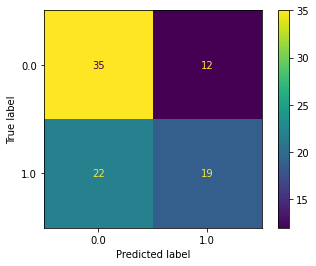


               precision    recall  f1-score   support

         0.0       0.61      0.74      0.67        47
         1.0       0.61      0.46      0.53        41

    accuracy                           0.61        88
   macro avg       0.61      0.60      0.60        88
weighted avg       0.61      0.61      0.61        88

ROC AUC: 75.09%


In [ ]:
selecao_LR.roda_pipeline_metricas(random_state=2347)


In [ ]:
# cria um objeto com a classe de seleção do modelo
selecao_RF = seleciona_modelo(RandomForestClassifier())
# seleção dos parâmetros de teste para este modelo
testes  = {'n_estimators': [10, 50, 100],
           'max_depth': [5, 10, 15],
           'criterion': ['gini', 'entropy']}
# vamos começar os testes das demais funções do pipeline de forma bem ampla
selecao_RF.testa_parametros(testes, metrica='roc_auc', lista_dados=[(dados_LE_0_2,'LE'),(dados_OHE_0_2,'OHE')],
                            lista_reescalas=['nenhuma',StandardScaler()],
                            selecao_menor=-100, selecao_maior=50, passo=50)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Finalizada iteração: seleção - sem seleção adicional, reescala - nenhuma, base - LE
Finalizada iteração: seleção - sem seleção adicional, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 0.5*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 0.5*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 1.0*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.0*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 1.5*mean, reescala - nenhuma, base - LE


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Finalizada iteração: seleção - 1.5*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - sem seleção adicional, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - sem seleção adicional, reescala - StandardScaler(), base - OHE
Finalizada iteração: seleção - 0.5*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 0.5*mean, reescala - StandardScaler(), base - OHE
Finalizada iteração: seleção - 1.0*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.0*mean, reescala - StandardScaler(), base - OHE
Finalizada iteração: seleção - 1.5*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.5*mean, reescala - StandardScaler(), base - OHE


,roc_auc,desvio_padrao,inferior,superior,base,reescala,threshold,qtd_variaveis,criterion,max_depth,n_estimators
4,0.802100,0.046123,0.709854,0.894346,LE,nenhuma,1.0*mean,34,entropy,10,100
0,0.806664,0.047860,0.710944,0.902384,LE,nenhuma,sem seleção adicional,91,gini,10,100
10,0.797477,0.042574,0.712328,0.882626,OHE,nenhuma,0.5*mean,45,gini,15,100
1,0.806031,0.046619,0.712793,0.899269,LE,StandardScaler(),sem seleção adicional,91,gini,15,100
2,0.803131,0.043282,0.716567,0.889695,LE,nenhuma,0.5*mean,40,gini,15,100


In [ ]:
# filtrando apenas a primeira janela de dados_LE
dados_LE_2_4 = adiciona_janela(dados_LE_0_2, dados_LE[dados_LE["WINDOW"] == '2-4'])
# filtrando apenas a primeira janela de dados_OHE utilizando outro forma de fazer isso
dados_OHE_2_4 = adiciona_janela(dados_OHE_0_2, dados_OHE.query("WINDOW == '2-4'"))

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`




Removemos as colunas que os valores são iguais para todas as linhas

Base nova de tamanho: (325, 663)

Removemos as colunas que os valores são iguais para todas as linhas

Base nova de tamanho: (325, 672)


In [ ]:
# cria um objeto com a classe de seleção do modelo
selecao_RF2 = seleciona_modelo(RandomForestClassifier())
# seleção dos parâmetros de teste para este modelo
testes  = {'n_estimators': [10, 50, 100],
           'max_depth': [5, 10, 15],
           'criterion': ['gini', 'entropy']}
# vamos começar os testes das demais funções do pipeline de forma bem ampla
selecao_RF2.testa_parametros(testes, metrica='roc_auc', lista_dados=[(dados_LE_2_4,'LE'),(dados_OHE_2_4,'OHE')],
                            lista_reescalas=['nenhuma',StandardScaler()],
                            selecao_menor=-100, selecao_maior=50, passo=50)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Finalizada iteração: seleção - sem seleção adicional, reescala - nenhuma, base - LE
Finalizada iteração: seleção - sem seleção adicional, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 0.5*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 0.5*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 1.0*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.0*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 1.5*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.5*mean, reescala - StandardScaler(), base - LE


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Finalizada iteração: seleção - sem seleção adicional, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - sem seleção adicional, reescala - StandardScaler(), base - OHE
Finalizada iteração: seleção - 0.5*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 0.5*mean, reescala - StandardScaler(), base - OHE
Finalizada iteração: seleção - 1.0*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.0*mean, reescala - StandardScaler(), base - OHE
Finalizada iteração: seleção - 1.5*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.5*mean, reescala - StandardScaler(), base - OHE


,roc_auc,desvio_padrao,inferior,superior,base,reescala,threshold,qtd_variaveis,criterion,max_depth,n_estimators
5,0.860778,0.039906,0.780966,0.940590,LE,StandardScaler(),1.0*mean,72,entropy,5,100
2,0.860587,0.039507,0.781572,0.939602,LE,nenhuma,0.5*mean,90,entropy,5,50
4,0.866436,0.037801,0.790834,0.942038,LE,nenhuma,1.0*mean,72,entropy,5,100
3,0.860640,0.034663,0.791314,0.929966,LE,StandardScaler(),0.5*mean,90,gini,5,100
9,0.858297,0.033002,0.792293,0.924300,OHE,StandardScaler(),sem seleção adicional,233,entropy,5,100


In [ ]:
testes  = {'n_estimators': [100],
           'max_depth': [4,6,8],
           'criterion': ['entropy']}
selecao_RF2.testa_parametros(testes, metrica='roc_auc', lista_dados=[(dados_LE_2_4,'LE')], lista_reescalas=[StandardScaler()],
                             selecao_menor=-20, selecao_maior=60, passo=20, n_repeats=30)

In [ ]:
selecao_RF2.cria_pipeline()
print('variávereis selecionadas:\n')
list(selecao_RF2.resultados.loc[selecao_RF2.indice,'selecionador'].get_feature_names_out())

In [ ]:
selecao_RF2.roda_pipeline_metricas(random_state=2347)

In [ ]:
selecao_RF2.pipe


In [ ]:
selecao_RF2.cria_salva_modelo_final('modelo_RF_2_4.joblib')
